<a href="https://colab.research.google.com/github/lohpaul9/deep-learning-hw-2/blob/main/train-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([16, 3, 32, 32])
torch.Size([16])


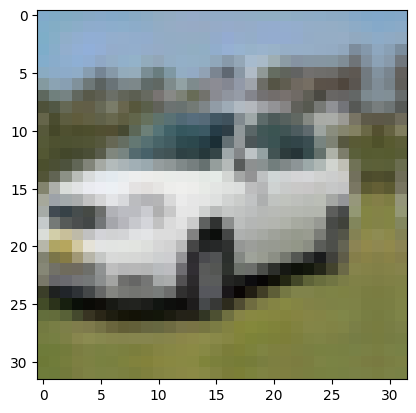

In [2]:
# Reading in the dataset
# Augmentations for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),  # Randomly crop images
    transforms.RandomRotation(5, interpolation=transforms.InterpolationMode.BILINEAR, fill=(127, 127, 127)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization
])

# Transform for test data (no augmentations)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print the shape of the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# print one of the images
img = images[0]
img = img / 2 + 0.5     # unnormalize

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()




# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5


        def convbn(channels_in,channels_out,kernel_size,stride=1,padding_size=0):
            return nn.Sequential(
                nn.Conv2d(channels_in,channels_out,kernel_size,stride=stride,padding=padding_size),
                nn.ReLU(True),
                nn.BatchNorm2d(channels_out))

        self.model = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.model.parameters()]))

    def forward(self, x):
        return self.model(x)

In [4]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        if epoch == 40:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.005
        if epoch == 80:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)

        # save the model
        torch.save(model.state_dict(), f'{model_name}_{epoch}.ckpt')
    return val_error,val_loss_values,train_error,train_loss_values


In [ ]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.7169
Epoch [1/100], Step [2000/3125], Loss: 1.2041
Epoch [1/100], Step [3000/3125], Loss: 1.4214
Accuracy of the network on the test images: 55.79 %
Epoch [2/100], Step [1000/3125], Loss: 1.2142
Epoch [2/100], Step [2000/3125], Loss: 0.8018
Epoch [2/100], Step [3000/3125], Loss: 1.2840
Accuracy of the network on the test images: 62.87 %
Epoch [3/100], Step [1000/3125], Loss: 1.0625
Epoch [3/100], Step [2000/3125], Loss: 0.7708
Epoch [3/100], Step [3000/3125], Loss: 0.9526
Accuracy of the network on the test images: 69.71 %
Epoch [4/100], Step [1000/3125], Loss: 0.9235
Epoch [4/100], Step [2000/3125], Loss: 0.7198
Epoch [4/100], Step [3000/3125], Loss: 0.6192
Accuracy of the network on the test images: 73.68 %
Epoch [5/100], Step [1000/3125], Loss: 0.5571
Epoch [5/100], Step [2000/3125], Loss: 0.7800
Epoch [5/100], Step [3000/3125], Loss: 0.7575
Accuracy of the network on the test images: 76.68 %
Epoch [6/100], Step [1000

In [ ]:
# load model
model = allcnn_t().to(device)
model.load_state_dict(torch.load('cnn_curve_99.ckpt'))

Num parameters:  1667166


<ipython-input-6-55851b8441e2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_curve_99.ckpt'))


<All keys matched successfully>

In [ ]:
# verify the accuracy of the saved model
def get_accuracy(model, test_loader):
      model.eval()
      with torch.no_grad():
          correct = 0
          total = 0
          for i, (images, labels) in enumerate(test_loader):
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

get_accuracy(model, testloader)


Accuracy of the network on the test images: 92.43 %


Files already downloaded and verified
Loss: 0.0010954929748550057
Accuracy: 100.00%
All perturbations within sanity check True
Loss: 4.514089107513428
Accuracy: 46.00%
All perturbations within sanity check True
Loss: 16.62643051147461
Accuracy: 10.00%
All perturbations within sanity check True
Loss: 29.51726531982422
Accuracy: 3.00%
All perturbations within sanity check True
Loss: 40.60386276245117
Accuracy: 1.00%
All perturbations within sanity check True
Loss: 50.171356201171875
Accuracy: 0.00%
All perturbations within sanity check True


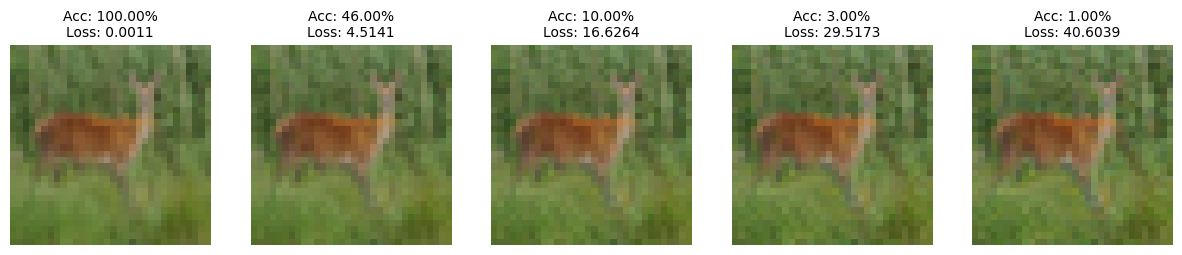

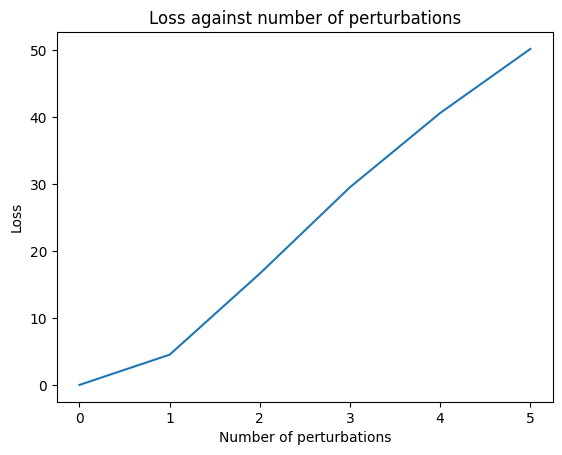

In [ ]:
eps_pixels = 2.0
eps_normalized = (eps_pixels / 255.0) / 0.5

def sanity_check_within_epsilon(unperturbed_img, perturbed_img, epsilon):
    # Change the images back to pixel space
    unperturbed_img = unperturbed_img.cpu().detach().numpy()
    perturbed_img = perturbed_img.cpu().detach().numpy()
    # Denormalize
    unperturbed_img = (unperturbed_img * 0.5 + 0.5) * 255
    perturbed_img = (perturbed_img * 0.5 + 0.5) * 255

    # Get the difference
    difference = unperturbed_img - perturbed_img
    difference = np.absolute(difference)

    # Check if the difference is within epsilon
    return np.all(difference <= (epsilon + 0.0001))


def adv_gradient_attack(model):
    model.eval()
    attack_set = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_test
    )
    subset_indices = torch.randperm(len(attack_set))[:100]
    attack_set = torch.utils.data.Subset(attack_set, subset_indices)
    attack_loader = torch.utils.data.DataLoader(attack_set, batch_size=100, shuffle=False)

    base_images, labels = next(iter(attack_loader))
    base_images = base_images.to(device)
    labels = labels.to(device)
    base_images.requires_grad = True

    perturbed_images_list = [base_images]
    imgs = []
    accuracies = []
    losses = []

    for perturbation_round in range(6):
        unperturbed = perturbed_images_list[-1]
        model.zero_grad()  # Clear gradients
        y = model(unperturbed)
        loss = criterion(y, labels)
        print(f"Loss: {loss.item()}")
        losses.append(loss.item())

        # Compute accuracy
        _, predicted = torch.max(y.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Accuracy: {accuracy:.2f}%")
        accuracies.append(accuracy)

        # Store the perturbed image for plotting
        img = unperturbed[0].cpu().detach().numpy() / 2 + 0.5  # Unnormalize
        imgs.append(img)

        loss.backward()
        x_grad = unperturbed.grad.data.clone()
        x_grad_sign = x_grad.sign()
        perturbation = x_grad_sign * eps_normalized

        # Apply perturbation and clamp values between 0 and 1
        perturbed = torch.clamp(unperturbed + perturbation, -1, 1).detach()

        print("All perturbations within sanity check", sanity_check_within_epsilon(unperturbed, perturbed, eps_pixels))

        perturbed.requires_grad = True
        perturbed_images_list.append(perturbed)

        # Zero the model gradients
        model.zero_grad()

    return imgs, accuracies, losses


# Run the adversarial attack
imgs, accuracies, losses = adv_gradient_attack(model)

# Plot 5 images (1 row x 5 columns) with accuracy and loss displayed
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (img, ax) in enumerate(zip(imgs[:5], axs)):
    ax.imshow(np.transpose(img, (1, 2, 0)))  # Transpose for imshow
    ax.set_title(f"Acc: {accuracies[i]:.2f}%\nLoss: {losses[i]:.4f}", fontsize=10)
    ax.axis('off')  # Turn off axis

# Adjust layout
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()


# plot the losses against the number of perturbations (0 to 5)
plt.plot(losses)
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.title('Loss against number of perturbations')
plt.show()